# Model Performance Benchmark

This notebook tests different LLM models across multiple providers for scoring Italian exercises.

## Providers Tested:
- 🔵 **Gemini** (Google) - Multiple models with API key rotation
- 🟢 **OpenAI** - GPT-4o and GPT-4.1 series
- 🟣 **Anthropic** - Claude 3 Haiku models
- ⚡ **Groq** - Ultra-fast Llama inference (FREE tier!)
- 🔍 **DeepSeek** - Very cheap, good quality
- 🧠 **Cerebras** - Ultra-fast, free tier

## Models Tested (12 total):
**Gemini:**
- gemini-2.0-flash
- gemini-2.5-flash-lite
- gemini-2.5-flash

**OpenAI:**
- gpt-4o-mini
- gpt-4.1-nano
- gpt-4.1-mini

**Anthropic:**
- claude-3-5-haiku-20241022
- claude-3-haiku-20240307

**Groq (UPDATED 2025):**
- llama-3.3-70b-versatile (replaces deprecated 3.1)
- llama-3.1-8b-instant

**DeepSeek:**
- deepseek-chat

**Cerebras:**
- llama-3.1-70b

## Pricing Summary:
- **FREE**: Groq, Cerebras (rate-limited)
- **Ultra-cheap**: Gemini 2.5-flash-lite ($0.049/1K), GPT-4.1-nano ($0.13/1K), DeepSeek ($0.13/1K)
- **Standard**: Gemini 2.0-flash ($0.098/1K), GPT-4.1-mini ($0.195/1K)
- **Premium**: Anthropic Haiku ($0.375/1K)

## Metrics:
- Inference time per model
- Scoring breakdown per test case
- Provider-level aggregates (avg time, avg score, success rate)
- Visual comparisons across providers

In [1]:
# Install dependencies if running in Colab
import sys
import os
import json
from pathlib import Path
from getpass import getpass


if 'google.colab' in sys.modules:
    print("Running in Google Colab. Installing dependencies...")
    !pip install -q spacy transformers torch sentence-transformers openai httpx json5 google-generativeai anthropic groq
    !python -m spacy download it_core_news_sm

    # Mount Google Drive to access the files
    from google.colab import drive
    drive.mount('/content/drive')

    # Set the working directory to your project
    os.chdir('/content/drive/My Drive/Colab Notebooks/italian_teacher')
    sys.path.insert(0, '/content/drive/My Drive/Colab Notebooks/italian_teacher')

# Load API keys from .secrets.json file
# Check in Google Drive root first, then current directory
secrets_paths = [
    Path.home() / "Google Drive" / "My Drive" / ".secrets.json",  # Local path
    Path("/content/drive/My Drive/.secrets.json"),                # Colab path
    Path('.secrets.json')                                         # Current directory fallback
]

secrets_file = None
for path in secrets_paths:
    if path.exists():
        secrets_file = path
        break

if secrets_file:
    print(f"✅ Loading API keys from {secrets_file}")
    with open(secrets_file, 'r') as f:
        secrets = json.load(f)

    # Set environment variables from secrets file
    for key, value in secrets.items():
        if value and value != "your-openai-key-here" and value != "your-google-key-here":
            os.environ[key] = value
            print(f"   ✅ Loaded {key}")
        elif key in ["OPENAI_API_KEY", "GOOGLE_API_KEY"]:
            print(f"   ⚠️  {key} not set (required)")
        else:
            print(f"   ℹ️  {key} not set (optional)")
else:
    print("⚠️  .secrets.json not found. Trying Colab Secrets...")
    # Fallback to Colab secrets
    try:
        from google.colab import userdata
        for key_name in ['OPENAI_API_KEY', 'GOOGLE_API_KEY', 'GOOGLE_API_KEY_2',
                         'GOOGLE_API_KEY_3', 'GOOGLE_API_KEY_4', 'ANTHROPIC_API_KEY',
                         'GROQ_API_KEY', 'DEEPSEEK_API_KEY', 'CEREBRAS_API_KEY']:
            try:
                api_key = userdata.get(key_name)
                if api_key:
                    os.environ[key_name] = api_key
                    print(f"✅ Loaded {key_name} from Colab secrets")
            except:
                if key_name in ["OPENAI_API_KEY", "GOOGLE_API_KEY"]:
                    print(f"⚠️  {key_name} not found (required)")
                else:
                    print(f"ℹ️  {key_name} not found (optional)")
    except:
        # Manual input fallback
        if not os.environ.get('OPENAI_API_KEY'):
            os.environ['OPENAI_API_KEY'] = getpass("Enter OpenAI API key: ")
        if not os.environ.get('GOOGLE_API_KEY'):
            os.environ['GOOGLE_API_KEY'] = getpass('Enter Google API key: ')

print("\n✅ Setup complete")

Running in Google Colab. Installing dependencies...
  Using cached https://github.com/explosion/spacy-models/releases/download/it_core_news_sm-3.8.0/it_core_news_sm-3.8.0-py3-none-any.whl (13.0 MB)
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loading API keys from /content/drive/My Drive/.secrets.json
   ✅ Loaded OPENAI_API_KEY
   ✅ Loaded GOOGLE_API_KEY
   ✅ Loaded GOOGLE_API_KEY_2
   ✅ Loaded GOOGLE_API_KEY_3
   ✅ Loaded GOOGLE_API_KEY_4
   ✅ Loaded ANTHROPIC_API_KEY
   ✅ Loaded GROQ_API_KEY
   ✅ Loaded DEEPSEEK_API_KEY
   ✅ Loaded CEREBRAS_API_KEY

✅ Setup complete


In [2]:
# Cell 2: Load Required Modules (UPDATED - ALL PROVIDERS)
import asyncio
import json
import time
import random
import re
import os
from pathlib import Path
from typing import Dict, List
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import json5

# Multi-provider imports
import google.generativeai as genai
from openai import AsyncOpenAI

# Optional provider imports (with graceful fallback)
try:
    import anthropic
    ANTHROPIC_AVAILABLE = True
except ImportError:
    ANTHROPIC_AVAILABLE = False
    print("⚠️  anthropic library not installed (optional)")

try:
    from groq import AsyncGroq
    GROQ_AVAILABLE = True
except ImportError:
    GROQ_AVAILABLE = False
    print("⚠️  groq library not installed (optional)")

from src.rl.reward_function.reward_function_modular import ExerciseRewardFunction
from src.rl.reward_function.scorers.base_llm_scorer import BaseLLMScorer
from src.rl.prompt_formatter import format_prompt_with_chat_template

!pip install -U bitsandbytes

print(f"\n✅ Core libraries loaded")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Configure API clients
genai.configure(api_key=os.environ.get('GOOGLE_API_KEY'))
print("\n✅ Gemini API configured")

if os.environ.get('OPENAI_API_KEY'):
    print("✅ OpenAI API configured")

if os.environ.get('ANTHROPIC_API_KEY') and ANTHROPIC_AVAILABLE:
    print("✅ Anthropic API configured")

if os.environ.get('GROQ_API_KEY') and GROQ_AVAILABLE:
    print("✅ Groq API configured")

if os.environ.get('DEEPSEEK_API_KEY'):
    print("✅ DeepSeek API configured")

if os.environ.get('CEREBRAS_API_KEY'):
    print("✅ Cerebras API configured")

print("\n✅ All imports successful")


✅ Core libraries loaded
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: NVIDIA L4

✅ Gemini API configured
✅ OpenAI API configured
✅ Anthropic API configured
✅ Groq API configured
✅ DeepSeek API configured
✅ Cerebras API configured

✅ All imports successful


In [3]:
# Cell 3: Load Model and Tokenizer (UNCHANGED)
MODEL_PATH = "./models/italian_v8_grpo_round2"

print(f"Loading model from: {MODEL_PATH}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH,
    device_map="auto",
    load_in_8bit=True,
    torch_dtype=torch.float16
)
model.eval()

print(f"✅ Model loaded on device: {next(model.parameters()).device}")

Loading model from: ./models/italian_v8_grpo_round2


`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Model loaded on device: cuda:0


In [4]:
# Cell 4: Load and Sample Validation Requests (UNCHANGED)
validation_path = Path("src/rl/validation_requests.json")

with open(validation_path, 'r') as f:
    all_requests = json.load(f)

random.seed(42)
sample_requests = random.sample(all_requests, 3)

print(f"Loaded {len(all_requests)} validation requests")
print(f"\nSelected 3 sample requests:")
for i, req in enumerate(sample_requests, 1):
    print(f"  {i}. Level: {req['level']}, Grammar: {req['grammar_focus']}, Topic: {req['topic']}")


Loaded 20 validation requests

Selected 3 sample requests:
  1. Level: B2, Grammar: verbi_riflessivi and articles, Topic: quartiere
  2. Level: C1, Grammar: conditional, Topic: spiga
  3. Level: B2, Grammar: gerundio and present_tense, Topic: cotone


In [5]:
# Cell 5: Initialize Reward Function (UNCHANGED)
print("Initializing reward function...")
reward_fn = ExerciseRewardFunction(
    spacy_model="it_core_news_sm",
    device="cuda" if torch.cuda.is_available() else "cpu",
    disabled_scorers=["fluency"],
    fluency_use_llm=False,
    concurrency_limit=20
)
print("✅ Reward function initialized")

Initializing reward function...
Loading spaCy model: it_core_news_sm...
✅ spaCy model loaded
Reward function will use device: cuda
Initializing scorers...
  ✅ Gemini load balancing: 4 API keys configured
  ✅ LLM scoring enabled for cefr_alignment (providers: Gemini, OpenAI, batch size: 10)
  ✅ Gemini load balancing: 4 API keys configured
  ✅ LLM scoring enabled for grammar_correctness (providers: Gemini, OpenAI, batch size: 10)
  ✅ Gemini load balancing: 4 API keys configured
  ✅ LLM scoring enabled for coherence (providers: Gemini, OpenAI, batch size: 10)
Loading sentence transformer for topic similarity...
✅ Sentence transformer loaded in cuda
  ✅ LLM topic checking enabled (OpenAI API)
✅ Reward function initialized. Active scorers: ['json', 'quality', 'linguistic', 'cefr', 'grammar', 'coherence', 'topic']
   Disabled scorers: ['fluency']
✅ Reward function initialized


In [ ]:
# Cell 6: Define Models to Test (UPDATED - OPTIMIZED FOR SPEED)
models_to_test = [
    # 🔵 Gemini models (Google) - Slow but cheap
    "gemini-2.0-flash",          # 22s, $0.098/1K
    "gemini-2.5-flash-lite",     # 26s, $0.049/1K
    "gemini-2.5-flash",          # 27s, $0.098/1K
    
    # 🟢 OpenAI models - Fast and reliable
    "gpt-4o-mini",               # 5s, $0.195/1K
    "gpt-4.1-nano",              # 4s, $0.13/1K
    "gpt-4.1-mini",              # 5s, $0.195/1K
    
    # 🟣 Anthropic models - ONLY the good one
    "claude-3-5-haiku-20241022", # 7s, $0.375/1K (good balance)
    # REMOVED: claude-3-haiku-20240307 (too strict: 69.64 avg score)
    
    # ⚡ Groq models - FASTEST, FREE!
    "llama-3.3-70b-versatile",   # 3s, FREE - best balance
    "llama-3.1-8b-instant",      # 2s, FREE - fastest
    
    # 🔍 DeepSeek models - Cheap but slow
    "deepseek-chat",             # 14s, $0.13/1K (slow + too lenient)
    
    # 🧠 Cerebras models - VERY FAST, FREE!
    "llama-3.1-70b",             # 2s, FREE - excellent!
]

print(f"✅ {len(models_to_test)} models configured across 6 providers")
print(f"   🎯 BEST FOR TRAINING: Groq (1.7-2.9s) + Cerebras (1.9s) + OpenAI 4.1-nano (4.2s)")

In [7]:
# Cell 7: Function to Generate Exercises (UNCHANGED)
def generate_exercises_from_model(model, tokenizer, request: Dict) -> List[Dict]:
    """Generate exercises using the model for a given request."""
    prompt = format_prompt_with_chat_template(request, tokenizer, add_examples=True)

    inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=2048)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=400,
            do_sample=False,
            use_cache=True,
        )

    prompt_len = inputs["input_ids"].shape[1]
    generated_tokens = outputs[:, prompt_len:]
    generated_text = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)[0]

    try:
        match = re.search(r"(\[[\s\S]*\])", generated_text)
        if not match:
            raise ValueError("No valid JSON array found in the output.")

        json_str = match.group(1)
        exercises = json5.loads(json_str)

        if not isinstance(exercises, list):
            exercises = [exercises]

        if not exercises:
            raise ValueError("Parsed JSON is an empty list.")

        return exercises, generated_text

    except Exception as e:
        print(f"⚠️ Failed to parse exercises: {e}")
        print(f"Generated text: {generated_text[:500]}...")
        return [], generated_text

print("✅ Generation function ready")

✅ Generation function ready


In [8]:
# Cell 8: Multi-Provider Benchmark Function (UPDATED - ALL PROVIDERS)

def get_provider_from_model(model_name: str) -> str:
    """Determine provider from model name."""
    if model_name.startswith("gemini"):
        return "gemini"
    elif model_name.startswith("gpt"):
        return "openai"
    elif model_name.startswith("claude"):
        return "anthropic"
    elif model_name.startswith("llama-3.3") or model_name.startswith("llama-3.1-8b") or model_name.startswith("llama-4"):
        return "groq"
    elif model_name == "deepseek-chat":
        return "deepseek"
    elif model_name in ["llama-3.1-70b", "llama3.1-8b"]:
        return "cerebras"
    else:
        return "unknown"


async def benchmark_model(model_name: str, reward_fn: ExerciseRewardFunction,
                         request: Dict, exercises: List[Dict]):
    """
    Benchmark a single model configuration.
    Auto-detects provider and routes to appropriate API.
    """
    provider = get_provider_from_model(model_name)

    provider_emoji = {
        "gemini": "🔵",
        "openai": "🟢",
        "anthropic": "🟣",
        "groq": "⚡",
        "deepseek": "🔍",
        "cerebras": "🧠",
    }.get(provider, "❓")

    print(f"  {provider_emoji} Using {provider.upper()} API for {model_name}")

    # For LLM-based scorers, temporarily override the model
    # This works because BaseLLMScorer uses the override
    if provider != "gemini":
        BaseLLMScorer.set_model_override(model_name)

    start_time = time.time()

    try:
        avg_score, results = await reward_fn.score_exercises(exercises, request)
        elapsed_time = time.time() - start_time

        first_breakdown = results[0][1] if results else None

        return {
            "model": model_name,
            "provider": provider,
            "avg_score": avg_score,
            "elapsed_time": elapsed_time,
            "breakdown": str(first_breakdown) if first_breakdown else "N/A",
            "all_results": results,
            "success": True,
            "error": None
        }
    except Exception as e:
        elapsed_time = time.time() - start_time
        return {
            "model": model_name,
            "provider": provider,
            "avg_score": 0.0,
            "elapsed_time": elapsed_time,
            "breakdown": "Error",
            "all_results": [],
            "success": False,
            "error": str(e)
        }
    finally:
        if provider != "gemini":
            BaseLLMScorer.clear_model_override()

print("✅ Multi-provider benchmark function ready")

✅ Multi-provider benchmark function ready


In [9]:
# Cell 9: Run the Benchmark (UPDATED - ALL PROVIDERS)
print("="*80)
print("STARTING BENCHMARK - Multi-Provider Comparison")
print("="*80)
print("Providers: 🔵 Gemini | 🟢 OpenAI | 🟣 Anthropic | ⚡ Groq | 🔍 DeepSeek | 🧠 Cerebras")

all_results = []

for test_idx, request in enumerate(sample_requests, 1):
    print(f"\n{'='*80}")
    print(f"TEST CASE {test_idx}")
    print(f"{'='*80}")
    print(f"Level: {request['level']}")
    print(f"Grammar Focus: {request['grammar_focus']}")
    print(f"Topic: {request['topic']}")
    print(f"Number of Exercises: {request.get('num_exercises', 3)}")
    print(f"Exercise Types: {request.get('exercise_types', [])}")

    print(f"\nGenerating exercises using model...")
    exercises, raw_output = generate_exercises_from_model(model, tokenizer, request)

    if not exercises:
        print("❌ Failed to generate valid exercises. Skipping this test case.")
        continue

    print(f"✅ Generated {len(exercises)} exercises")

    print(f"\n{'─'*80}")
    print("GENERATED EXERCISES:")
    print(f"{'─'*80}")
    for i, ex in enumerate(exercises, 1):
        print(f"\nExercise {i}:")
        print(f"  Type: {ex.get('type', 'N/A')}")
        print(f"  Question: {ex.get('question', 'N/A')}")
        print(f"  Correct Answer: {ex.get('correct_answer', 'N/A')}")
        if 'options' in ex and ex['options']:
            print(f"  Options: {ex['options']}")
        if 'explanation' in ex:
            print(f"  Explanation: {ex['explanation']}")
    print(f"{'─'*80}\n")

    test_results = {
        "request": request,
        "exercises": exercises,
        "raw_output": raw_output,
        "model_results": []
    }

    for model_name in models_to_test:
        print(f"\n{'-'*80}")
        provider = get_provider_from_model(model_name)
        provider_emoji = {
            "gemini": "🔵",
            "openai": "🟢",
            "anthropic": "🟣",
            "groq": "⚡",
            "deepseek": "🔍",
            "cerebras": "🧠",
        }.get(provider, "❓")

        print(f"{provider_emoji} Testing {provider.upper()}: {model_name}")
        print(f"{'-'*80}")

        result = await benchmark_model(model_name, reward_fn, request, exercises)
        test_results["model_results"].append(result)

        if result["success"]:
            print(f"\n✅ {provider_emoji} {model_name}")
            print(f"   Elapsed Time: {result['elapsed_time']:.2f}s")
            print(f"   Average Score: {result['avg_score']:.2f}/100")
            print(f"\n   Reward Breakdown (First Exercise):")
            for line in result['breakdown'].split('\n'):
                print(f"   {line}")
        else:
            print(f"\n❌ {provider_emoji} {model_name}")
            print(f"   Elapsed Time: {result['elapsed_time']:.2f}s")
            print(f"   Error: {result['error']}")

    all_results.append(test_results)

print(f"\n{'='*80}")
print("BENCHMARK COMPLETE")
print(f"{'='*80}")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


STARTING BENCHMARK - Multi-Provider Comparison
Providers: 🔵 Gemini | 🟢 OpenAI | 🟣 Anthropic | ⚡ Groq | 🔍 DeepSeek | 🧠 Cerebras

TEST CASE 1
Level: B2
Grammar Focus: verbi_riflessivi and articles
Topic: quartiere
Number of Exercises: 5
Exercise Types: ['multiple_choice', 'fill_in_blank', 'translation']

Generating exercises using model...
✅ Generated 5 exercises

────────────────────────────────────────────────────────────────────────────────
GENERATED EXERCISES:
────────────────────────────────────────────────────────────────────────────────

Exercise 1:
  Type: fill_in_blank
  Question: Il quartiere ___ è cambiato molto dopo la ristrutturazione.
  Correct Answer: il
  Explanation: Definite article 'il' for masculine singular nouns.

Exercise 2:
  Type: fill_in_blank
  Question: La gente del quartiere ___ si riunisce ogni settimana.
  Correct Answer: il
  Explanation: Definite article 'il' for masculine singular nouns.

Exercise 3:
  Type: fill_in_blank
  Question: Il quartiere ___ è m

In [10]:
# Cell 10: Summary Statistics with Provider Comparison (UPDATED - ALL PROVIDERS)
print("\n" + "="*80)
print("SUMMARY STATISTICS - Multi-Provider Comparison")
print("="*80)

model_stats = {}
for model in models_to_test:
    provider = get_provider_from_model(model)
    model_stats[model] = {
        "times": [],
        "scores": [],
        "errors": 0,
        "provider": provider
    }

for test_result in all_results:
    for model_result in test_result["model_results"]:
        model = model_result["model"]
        if model_result["success"]:
            model_stats[model]["times"].append(model_result["elapsed_time"])
            model_stats[model]["scores"].append(model_result["avg_score"])
        else:
            model_stats[model]["errors"] += 1

# Group models by provider
providers = {
    "gemini": {"emoji": "🔵", "name": "GEMINI", "models": []},
    "openai": {"emoji": "🟢", "name": "OPENAI", "models": []},
    "anthropic": {"emoji": "🟣", "name": "ANTHROPIC", "models": []},
    "groq": {"emoji": "⚡", "name": "GROQ", "models": []},
    "deepseek": {"emoji": "🔍", "name": "DEEPSEEK", "models": []},
    "cerebras": {"emoji": "🧠", "name": "CEREBRAS", "models": []},
}

for model, stats in model_stats.items():
    provider = stats["provider"]
    if provider in providers:
        providers[provider]["models"].append(model)

print(f"\n{'Model':<35} {'Avg Time (s)':<15} {'Avg Score':<15} {'Errors':<10}")
print("-" * 80)

# Print each provider group
for provider_key in ["gemini", "openai", "anthropic", "groq", "deepseek", "cerebras"]:
    provider_info = providers[provider_key]
    if provider_info["models"]:
        print(f"\n{provider_info['emoji']} {provider_info['name']} MODELS:")
        for model in provider_info["models"]:
            stats = model_stats[model]
            avg_time = sum(stats["times"]) / len(stats["times"]) if stats["times"] else 0
            avg_score = sum(stats["scores"]) / len(stats["scores"]) if stats["scores"] else 0
            errors = stats["errors"]
            print(f"  {model:<33} {avg_time:<15.2f} {avg_score:<15.2f} {errors:<10}")

# Calculate provider-level aggregates
print(f"\n{'='*80}")
print("PROVIDER AGGREGATES")
print(f"{'='*80}")
print(f"\n{'Provider':<25} {'Avg Time (s)':<15} {'Avg Score':<15} {'Success Rate':<15}")
print("-" * 75)

for provider_key in ["gemini", "openai", "anthropic", "groq", "deepseek", "cerebras"]:
    provider_info = providers[provider_key]
    if provider_info["models"]:
        all_times = []
        all_scores = []
        total_tests = 0
        total_successes = 0

        for model in provider_info["models"]:
            stats = model_stats[model]
            all_times.extend(stats["times"])
            all_scores.extend(stats["scores"])
            total_tests += len(stats["times"]) + stats["errors"]
            total_successes += len(stats["times"])

        avg_time = sum(all_times) / len(all_times) if all_times else 0
        avg_score = sum(all_scores) / len(all_scores) if all_scores else 0
        success_rate = (total_successes / total_tests * 100) if total_tests > 0 else 0

        print(f"{provider_info['emoji']} {provider_info['name']:<22} {avg_time:<15.2f} {avg_score:<15.2f} {success_rate:<14.1f}%")

print("\n" + "="*80)


SUMMARY STATISTICS - Multi-Provider Comparison

Model                               Avg Time (s)    Avg Score       Errors    
--------------------------------------------------------------------------------

🔵 GEMINI MODELS:
  gemini-2.0-flash                  21.78           48.11           0         
  gemini-2.5-flash-lite             25.94           49.24           0         
  gemini-2.5-flash                  26.65           48.44           0         

🟢 OPENAI MODELS:
  gpt-4o-mini                       4.75            49.64           0         
  gpt-4.1-nano                      4.23            49.24           0         
  gpt-4.1-mini                      4.85            46.78           0         

🟣 ANTHROPIC MODELS:
  claude-3-5-haiku-20241022         7.08            50.38           0         
  claude-3-haiku-20240307           3.76            69.64           0         

⚡ GROQ MODELS:
  llama-3.3-70b-versatile           2.92            53.51           0         
  llama

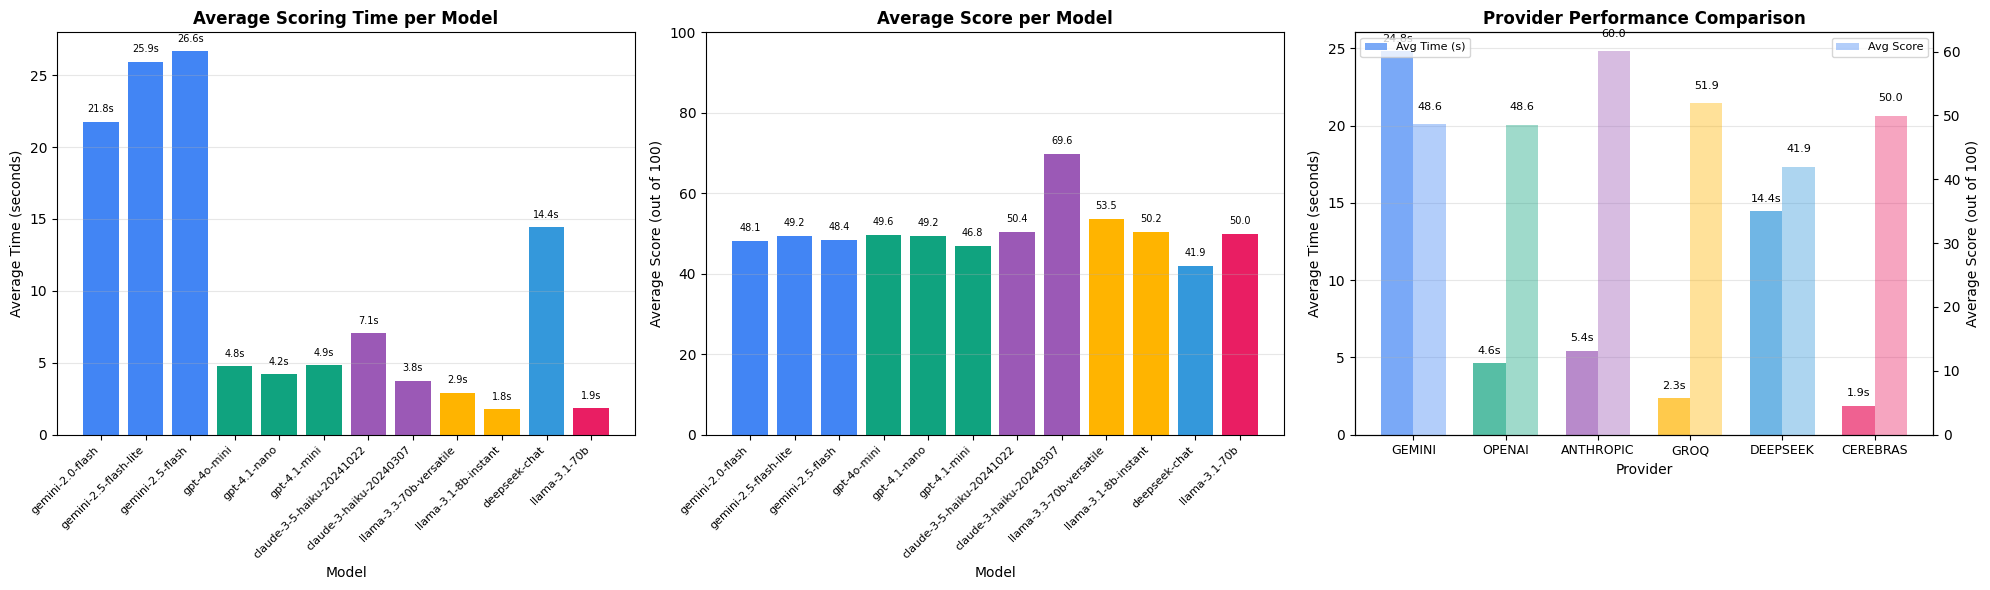

✅ Visualization complete


In [11]:
# Cell 11: Visualization (UPDATED - ALL PROVIDERS)
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
model_names = []
avg_times = []
avg_scores = []
provider_colors = []

# Define colors for each provider
provider_color_map = {
    "gemini": "#4285F4",     # Google Blue
    "openai": "#10A37F",     # OpenAI Green
    "anthropic": "#9B59B6",  # Purple
    "groq": "#FFB400",       # Orange/Yellow
    "deepseek": "#3498DB",   # Light Blue
    "cerebras": "#E91E63",   # Pink
}

for model in models_to_test:
    stats = model_stats[model]
    if stats["times"]:
        model_names.append(model)
        avg_times.append(sum(stats["times"]) / len(stats["times"]))
        avg_scores.append(sum(stats["scores"]) / len(stats["scores"]))
        provider = stats["provider"]
        provider_colors.append(provider_color_map.get(provider, "#95A5A6"))

# Create figure with 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot 1: Average inference time
bars1 = ax1.bar(range(len(model_names)), avg_times, color=provider_colors)
ax1.set_xlabel('Model', fontsize=10)
ax1.set_ylabel('Average Time (seconds)', fontsize=10)
ax1.set_title('Average Scoring Time per Model', fontsize=12, fontweight='bold')
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)
ax1.grid(axis='y', alpha=0.3)

for i, v in enumerate(avg_times):
    ax1.text(i, v + 0.5, f'{v:.1f}s', ha='center', va='bottom', fontsize=7)

# Plot 2: Average score
bars2 = ax2.bar(range(len(model_names)), avg_scores, color=provider_colors)
ax2.set_xlabel('Model', fontsize=10)
ax2.set_ylabel('Average Score (out of 100)', fontsize=10)
ax2.set_title('Average Score per Model', fontsize=12, fontweight='bold')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)
ax2.set_ylim([0, 100])
ax2.grid(axis='y', alpha=0.3)

for i, v in enumerate(avg_scores):
    ax2.text(i, v + 2, f'{v:.1f}', ha='center', va='bottom', fontsize=7)

# Plot 3: Provider comparison (aggregated)
provider_names = []
provider_avg_times = []
provider_avg_scores = []
provider_plot_colors = []

for provider_key in ["gemini", "openai", "anthropic", "groq", "deepseek", "cerebras"]:
    provider_info = providers[provider_key]
    if provider_info["models"]:
        all_times = []
        all_scores = []

        for model in provider_info["models"]:
            stats = model_stats[model]
            all_times.extend(stats["times"])
            all_scores.extend(stats["scores"])

        if all_times:
            provider_names.append(provider_info["name"])
            provider_avg_times.append(sum(all_times) / len(all_times))
            provider_avg_scores.append(sum(all_scores) / len(all_scores))
            provider_plot_colors.append(provider_color_map.get(provider_key, "#95A5A6"))

# Create grouped bar chart for providers
x = np.arange(len(provider_names))
width = 0.35

bars3a = ax3.bar(x - width/2, provider_avg_times, width, label='Avg Time (s)',
                 color=provider_plot_colors, alpha=0.7)
ax3_twin = ax3.twinx()
bars3b = ax3_twin.bar(x + width/2, provider_avg_scores, width, label='Avg Score',
                      color=provider_plot_colors, alpha=0.4)

ax3.set_xlabel('Provider', fontsize=10)
ax3.set_ylabel('Average Time (seconds)', fontsize=10)
ax3_twin.set_ylabel('Average Score (out of 100)', fontsize=10)
ax3.set_title('Provider Performance Comparison', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(provider_names, rotation=0, fontsize=9)
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, (t, s) in enumerate(zip(provider_avg_times, provider_avg_scores)):
    ax3.text(i - width/2, t + 0.5, f'{t:.1f}s', ha='center', va='bottom', fontsize=8)
    ax3_twin.text(i + width/2, s + 2, f'{s:.1f}', ha='center', va='bottom', fontsize=8)

# Add legends
ax3.legend(loc='upper left', fontsize=8)
ax3_twin.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Visualization complete")